# BoTorch Tutorials

_Drew Gjerstad_

**Includes content from BoTorch's
[documentation](https://botorch.org/docs/introduction) and
[tutorials](https://botorch.org/docs/tutorials/).**

This notebook contains tutorials showing how to use BoTorch effectively. The
tutorials in this notebook are list (and linked) below, organized in the same
manner as on BoTorch's site. Note that while the links work in Visual Studio
Code, there have been issues reported in GitHub Preview and popular viewing
tools like `nbviewer`.

## Contents

[**Full Optimization Loops**](#full-optimization-loops)

 * [Trust Region Bayesian Optimization with TuRBO](#trust-region-bayesian-optimization-with-turbo)
 * [High-Dimensional Bayesian Optimization with SAASBO](#high-dimensional-bayesian-optimization-with-saasbo)

[**Bite-Sized Tutorials**](#bite-sized-tutorials)

 * [Implementing Custom Acquisition Functions](#implementing-custom-acquisition-functions)
 * [Information-Theoretic Acquisition Functions](#information-theoretic-acquisition-functions)

[**Advanced Usage**](#advanced-usage)

## Full Optimization Loops
The tutorials in this section are focused on defining entire optimization loops
using BoTorch.

### Trust Region Bayesian Optimization with TuRBO
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/turbo_1/)

In this tutorial, we focus on implementing **Trust Region Bayesian**
**Optimization** ([TuRBO](
https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf))
in a closed loop in BoTorch. In these examples, we will use one trust region
(TuRBO-1) and two different acquisition functions: parallel expected
improvement (qEI) and Thompson sampling (TS). We will apply the implementation
to the 20-dimensional Ackley function on the domain $[-5, 10]^{20}$. We find
that TuRBO-1 performs better than both qEI and Sobol. Keep in mind that since
BoTorch focuses on maximization, we will need to switch the sign of the
objective to find the minimum of the Ackley function:

\begin{equation*}
    -f(x) \rightarrow \max_{x}-f(x) = 0
\end{equation*}

In [17]:
# Load Dependencies
import os
import math
import warnings
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning, NumericsWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Tensor Keyword Arguments
tkwargs = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dtype": torch.double,
}

Let's review our objective: optimize the 20-dimensional Ackley function. The
Ackley function is a popular function for testing the capabilities for novel
optimization approaches and is given by

\begin{equation*}
    f(x_1,\dots,x_d) = -20\exp(-0.2\sqrt{\frac{1}{d}\sum_{j=1}^{d}x_j^2}) -
    \exp(\frac{1}{d}\sum_{j=1}^{d}\cos(2\pi x_j)) + 20 + e
\end{equation*}

on the domain $[-5, 10]^{20}$. Note that the global optimal value of 0 is
found at $x_1 = \dots = x_d = 0$ (the "origin"). As mentioned above, we will
flip the sign of the Ackley function since BoTorch assumes maximization.

In [3]:
# Ackley Function
ackley = Ackley(dim=20, negate=True).to(**tkwargs)
ackley.bounds[0, :].fill_(-5)
ackley.bounds[1, :].fill_(10)
dim = ackley.dim
lb, ub = ackley.bounds

# Hyperparameters
BATCH_SIZE = 4
N_INITIAL = 2 * dim
MAX_CHOLESKY_SIZE = float("inf")    # always use Cholesky

# Define Objective Evaluation
def objective(x):
    """
    This is a helper function that we will use to unnormalize and evaluate a
    point `x`.
    """
    return ackley(unnormalize(x, ackley.bounds))

The TuRBO algorithm must maintain a state for the trust region, tracking the
length of the trust region, success and failure counters, success and failure
tolerance, among other attributes. The author of this tutorial uses a dataclass
to store this information and then update it after every batch evaluation. Note
that we will assume the domain is scaled to $[0,1]^d$ and that the batch size is
constant.

In [7]:
# TuRBO State

@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tol: int = float("nan")     # post-initialized
    success_counter = 0
    success_tol: int = 10               # original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tol = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter +=1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1
    
    if state.success_counter == state.success_tol:
        # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tol:
        # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0
    
    # Update best value
    state.best_value = max(state.best_value, max(Y_next).item())

    # Trigger restart if necessary
    if state.length < state.length_min:
        state.restart_triggered = True
    
    return state

In [8]:
# Inspect State
state = TurboState(dim=dim, batch_size=BATCH_SIZE)
print(state)

TurboState(dim=20, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tol=5, success_tol=10, best_value=-inf, restart_triggered=False)


Next, we will define a function to generate a set of initial points used to
start the optimization loop.

In [9]:
# Generate Initial Points
def get_initial_points(dim, n_points, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_points).to(**tkwargs)
    return X_init

To acquire points during the optimization loop, we will define a function that
generates a batch of points using either Thompson sampling (TS) or parallel
expected improvement (qEI) via the `acqf` argument. Note that we assume the
domain of the observations are $[0, 1]^d$ (i.e., not the Ackley's domain). In
addition, we will use the current Turbo state and probabilistic GP model from
previous observations to aid in the acquisition of new observations.

In [10]:
# Generate New Batches
def generate_batch(state, model, X, Y, batch_size, n_candidates=None,
                   n_restarts=10, raw_samples=512, acqf="ts"):
    # `model`: GP model
    # `X`: evaluated points on the domain [0, 1]^d
    # `Y`: function values
    # `n_candidates`: number of candidates for Thompson sampling
    # `acqf`: "ei" or "ts" for expected improvement and Thompson sampling, resp.

    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    if n_candidates is None:
        n_candidates = min(5_000, max(2_000, 200 * X.shape[-1]))
    
    # Scale trust region to be proportional to lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights /= weights.mean()
    weights /= torch.prod(weights.pow(1.0 / weights.numel()))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        # Acquisition Function --> Thompson sampling (TS)
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(**tkwargs)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create Perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, **tkwargs) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device="cpu")] = 1

        # Create Candidate Points from Perturbations and Mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample Candidate Points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():
            # No gradients required when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        # Acquisition Function --> Parallel Expected Improvement
        ei = qExpectedImprovement(model, Y.max())
        X_next, acq_val = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=n_restarts,
            raw_samples=raw_samples,
        )

    return X_next

Now that we can sample an initial set as well as batches during the optimization
loop, we can now define our optimization loop. This loop will run one instance
of TuRBO-1 with Thompson sampling until convergence.

Some background about TuRBO-1 is that it is a local optimizer which can be used
for problems with fixed evaluation budgets (with restarts). Once the algorithm
converges, `state["restart_triggered"]` will be True and the run should be
aborted. If one wants to perform more evaluations then simply generate a new set
of initial points and keep generating batches until convergence or until the
evaluation budget is reached. Finally, keep in mind that the evaluations from
previous instances are discarded upon restart.

In [12]:
# Optimization Loop

# Initial Data Points
X_turbo = get_initial_points(dim, N_INITIAL)
Y_turbo = torch.tensor(
    [objective(x) for x in X_turbo], **tkwargs
).unsqueeze(-1)

# Initialize TuRBO State
state = TurboState(
    dim=dim, batch_size=BATCH_SIZE, best_value=max(Y_turbo).item()
)

# Set Hyperparameters
N_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5_000, max(2_000, 200 * dim)) if not SMOKE_TEST else 4

# Set Seed
torch.manual_seed(0)

# Run Loop (until convergence)
while not state.restart_triggered:
    # Fit GP Model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # use same lengthscale prior as paper
        MaternKernel(
            nu=2.5,
            ard_nums_dims=dim,
            lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Perform Fitting and Acquisition Function Optimization w/ Cholesky
    with gpytorch.settings.max_cholesky_size(MAX_CHOLESKY_SIZE):
        # Fit Model
        fit_gpytorch_mll(mll)

        # Create Batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            n_restarts=N_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )
    
    # Evaluate Objective at New Locations
    Y_next = torch.tensor(
        [objective(x) for x in X_next], **tkwargs
    ).unsqueeze(-1)

    # Update State
    state = update_state(state=state, Y_next=Y_next)

    # Augment Data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

# Print Final Status
print(f"{len(X_turbo)}) Best value: {state.best_value:.2e}")

500) Best value: -1.39e-01


In the next two code cells, we will compare TuRBO to qLogEI and qEI. After that
we will make plots comparing their progress and outcome.

In [13]:
# GP-LogEI
torch.manual_seed(0)

X_logei = get_initial_points(dim, N_INITIAL)
Y_logei = torch.tensor(
    [objective(x) for x in X_logei], **tkwargs
).unsqueeze(-1)

# Cap Evaluations when Running Smoke Test
max_evals = min(len(Y_turbo), N_INITIAL + 2 * BATCH_SIZE) if SMOKE_TEST else len(Y_turbo)

# Loop
while len(Y_logei) < max_evals:
    # Fit Model
    train_Y = (Y_logei - Y_logei.mean()) / Y_logei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_logei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create Batch
    log_ei = qLogExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        log_ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, **tkwargs),
                torch.ones(dim, **tkwargs)
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=N_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    
    # Evaluate Objective at New Locations
    Y_next = torch.tensor(
        [objective(x) for x in candidate], **tkwargs
    ).unsqueeze(-1)

    # Augment Data
    X_logei = torch.cat((X_logei, candidate), dim=0)
    Y_logei = torch.cat((Y_logei, Y_next), dim=0)

# Print Final Status
print(f"{len(X_logei)}) Best value: {Y_logei.max().item():.2e}")

500) Best value: -3.11e+00


In [18]:
# GP-EI
torch.manual_seed(0)

# Suppress Numeric Warning for qEI
warnings.filterwarnings("ignore", category=NumericsWarning)

X_ei = get_initial_points(dim, N_INITIAL)
Y_ei = torch.tensor(
    [objective(x) for x in X_ei], **tkwargs
).unsqueeze(-1)

# Loop
while len(Y_ei) < len(Y_turbo):
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create Batch
    ei = qExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, **tkwargs),
                torch.ones(dim, **tkwargs)
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=N_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # Evaluate Objective at New Locations
    Y_next = torch.tensor(
        [objective(x) for x in candidate], **tkwargs
    ).unsqueeze(-1)

    # Augment Data
    X_ei = torch.cat((X_ei, candidate), dim=0)
    Y_ei = torch.cat((Y_ei, Y_next), dim=0)

# Print Final Status
print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

500) Best value: -9.11e+00


Before we plot the progress and outcome to compare TuRBO against parallel
expected improvement (qEI) and parallel log expected improvement (qLogEI), we
will also use Sobol sampling to find the optimum. This will also be included in
the comparison plot.

In [15]:
# Sobol

X_Sobol = (
    SobolEngine(dim, scramble=True, seed=0)
    .draw(len(X_turbo))
    .to(**tkwargs)
)
Y_Sobol = torch.tensor(
    [objective(x) for x in X_Sobol], **tkwargs
).unsqueeze(-1)

print(f"{len(X_Sobol)}) Best value: {Y_Sobol.max().item():.2e}")

500) Best value: -1.06e+01


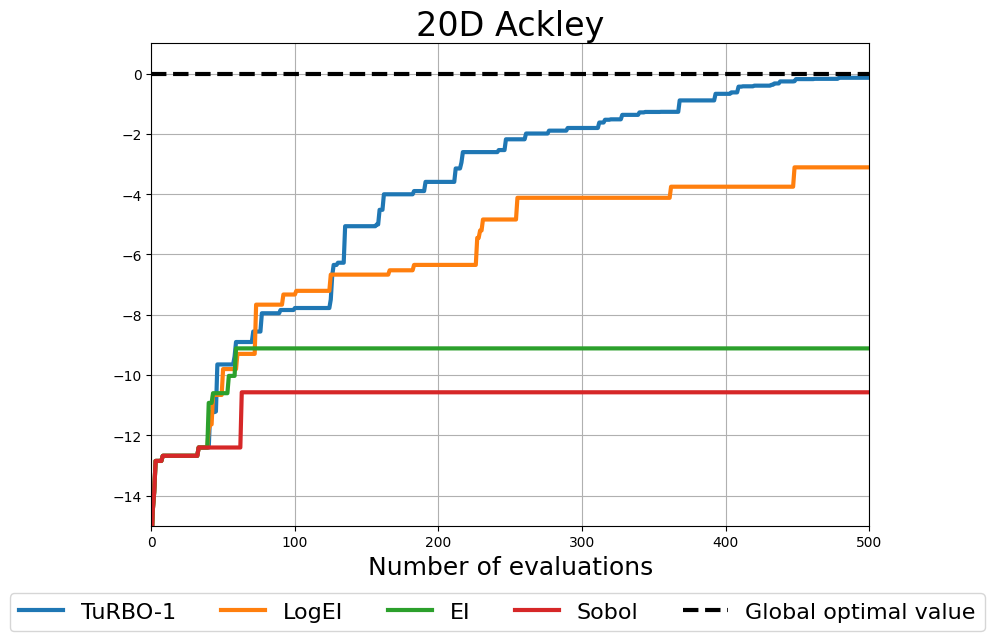

In [22]:
# Plot Progress and Outcome
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

names = ["TuRBO-1", "LogEI", "EI", "Sobol"]
runs = [Y_turbo, Y_logei, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [ackley.optimal_value, ackley.optimal_value],
         "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=5,
    fontsize=16,
)
plt.show()

### High-Dimensional Bayesian Optimization with SAASBO
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/saasbo/)

In this tutorial, we review how to implement **Sparse Axis-Aligned Subspace**
**Bayesian Optimization**
([SAASBO](https://proceedings.mlr.press/v161/eriksson21a.html)) for
high-dimensional Bayesian optimization. The SAASBO method avoids the
over-fitting in high-dimensional spaces by placing strong priors on the inverse
lengthscales. In particular, SAASBO makes use of a hierarchical sparsity prior
incorporating a global shrinkage parameter $\tau\sim\mathcal{HC}(\beta)$ and
inverse lengthscales $\rho_{d}\sim\mathcal{HC}(\tau)$ for $d=1,\dots,D$ where
$\mathcal{HC}$ denotes the half-Cauchy distribution. While the half-Cauchy
distribution favors values near zero, they also have heavy tails that help the
inverse lengthscales for the most important parameters to avoid zero.

The tutorial's author notes that for performing inference in the SAAS model we
will use Hamiltonian Monte Carlo (HMC) as it was found to outperform MAP
inference. In addition, SAASBO performs well for problems with hundreds of
dimensions but since we are relying on HMC for inference, SAASBO's overhead
scales cubically with the number of samples. Thus, depending on the problem,
using more than a few hundred samples may be infeasible due to SAASBO's design
being advantageous for problems with limited evaluation budget.

In [4]:
# Load Dependencies
import sys
import os

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [5]:
# Define Tensor Keyword Arguments
tkwargs = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double
}

To avoid increased overhead and decrease the time it takes to fit the SAAS model
by lowering `WARMUP_STEPS` and `NUM_SAMPLES`. The author recommends using 512
warmup steps and 256 samples when possible and avoid using less than 256 warmup
steps and 128 samples. The default practice is to only keep each 16th sample
meaning for 256 samples results in 32 hyperparameter samples (this is controlled
via the `THINNING` variable below).

To keep this tutorial efficient, the author uses 256 warmup steps and 128
samples.

In [6]:
WARMUP_STEPS = 256 if not SMOKE_TEST else 32
NUM_SAMPLES = 128 if not SMOKE_TEST else 16
THINNING = 16

Next, we start by reviewing how to fit a simple model. To do this, we generate
a simple function that is only dependent on the first parameter to demonstrate
that the SAAS model sets all other lengthscales to large values.

In [7]:
# Generate Simple Function
train_X = torch.rand(10, 4, **tkwargs)
test_X = torch.rand(5, 4, **tkwargs)
train_Y = torch.sin(train_X[:, :1])
test_Y = torch.sin(test_X[:, :1])

Typically, we will infer the _unknown_ noise variance in the data. However, we
can specify the known noise variant (`train_Yvar`) for each observation. This is
particularly useful if we know that the problem is noise-free and we can set the
noise variant to a small value such as `1e-6`. Then, we can construct a model
for this case as shown in the next code cell.

In [9]:
# Construct GP Model (known noise variant)
gp = SaasFullyBayesianSingleTaskGP(train_X=train_X,
                                   train_Y=train_Y,
                                   train_Yvar=torch.full_like(train_Y, 1e-6))

In the next code cell, we define the model for this tutorial and example.

In [10]:
# Construct GP Model
gp = SaasFullyBayesianSingleTaskGP(train_X=train_X,
                                   train_Y=train_Y,
                                   outcome_transform=Standardize(m=1))

fit_fully_bayesian_model_nuts(
    gp,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    thinning=THINNING,
    disable_progbar=True,
)

with torch.no_grad():
    posterior = gp.posterior(test_X)

To show that the first feature has the smallest lengthscale, we can compute the
median lengthscales over the MCMC dimensions.

In [11]:
print(gp.median_lengthscale.detach())

tensor([ 2.3037, 12.0275, 38.1321, 18.8247], dtype=torch.float64)


Now that the model is trained, we can use it to make predictions. In the cell
below, we make predictions with the SAAS model in the same fashion as other
posteriors in BoTorch: computing the mean and variance for test points. Note
that the mean and posterior tensors have an extra batch dimension at -3
corresponding to the number of MCMC samples (8 in this tutorial).

In [12]:
# Print Dimensions of Posterior Mean and Variance
print(posterior.mean.shape)
print(posterior.variance.shape)

torch.Size([8, 5, 1])
torch.Size([8, 5, 1])


Additionally, BoTorch also provides methods to easily compute different
statistics across the MCMC samples, as shown below.

In [15]:
# Compute Statistics over MCMC Samples
mixture_mean = posterior.mixture_mean
mixture_variance = posterior.mixture_variance
mixture_quantile = posterior.quantile(torch.tensor(0.95))

print(f"Ground Truth:   {test_Y.squeeze(-1)}")
print(f"Mixture Mean:   {mixture_mean.squeeze(-1)}")

Ground Truth:   tensor([0.2099, 0.5055, 0.2166, 0.7694, 0.1876], dtype=torch.float64)
Mixture Mean:   tensor([0.2068, 0.5038, 0.2135, 0.7700, 0.1871], dtype=torch.float64)


Since we have an understanding of how to implement SAASBO using BoTorch, we can
apply the method to optimize Branin embedded in a 30-dimensional space.
Specifically, we embed the standard two-dimensional Branin problem in a
30-dimensional space with dimensions 0 and 1 corresponding to the true
dimensions. This exercise demonstrates that SAASBO can identify the critical
dimensions and optimize this function efficiently. Note that we will work with
the domain $[0,1]^d$ and unnormalize the inputs to true domain of Branin before
we evaluate the function.

In [19]:
# Prepare Branin Problem
branin = Branin().to(**tkwargs)

def branin_emb(x):
    """x is assumed to be in [0, 1]^d"""
    lb, ub = branin.bounds
    return branin(lb + (ub - lb) * x[..., :2])

In the next cell, we define the dimensions and evaluation budget.

In [17]:
# Define Problem Dimensions
DIM = 30 if not SMOKE_TEST else 2

# Define Evaluation Budget
N_INIT = 10
N_ITERATIONS = 8 if not SMOKE_TEST else 1
BATCH_SIZE = 5 if not SMOKE_TEST else 1
print(f"Using a total of {N_INIT + BATCH_SIZE * N_ITERATIONS} function evaluations")

Using a total of 50 function evaluations


We can now run the optimization with 10 initial Sobol (a type of sampling)
points and then 8 iterations of Bayesian optimization using the batch size of 5
defined above, resulting in a total of 50 function evaluations. Note that we
will flip the sign of the function values before fitting the SAAS model since
our focus is minimizing Branin. This is due to the fact that in BoTorch, the
acquisition functions assume maximization.

In [20]:
X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(N_INIT).to(**tkwargs)
Y = branin_emb(X).unsqueeze(-1)
print(f"Best initial point: {Y.min().item():.3f}")

for i in range(N_ITERATIONS):
    train_Y = -1 * Y  # Flip sign to minimize the function
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=X,
        train_Y=train_Y,
        train_Yvar=torch.full_like(train_Y, 1e-6),
        outcome_transform=Standardize(m=1),
    )
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    # Use the Batch Log Expected Improvement (EI) Acquisition Function
    EI = qLogExpectedImprovement(model=gp, best_f=train_Y.max())
    candidates, acq_values = optimize_acqf(
        EI,
        bounds=torch.cat((torch.zeros(1, DIM), torch.ones(1, DIM))),
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=1024,
    )

    # Get Next Set of Function Evaluations
    Y_next = torch.cat([branin_emb(x).unsqueeze(-1) for x in candidates]).unsqueeze(-1)
    if Y_next.min() < Y.min():
        ind_best = Y_next.argmin()
        x0, x1 = candidates[ind_best, :2].tolist()
        print(
            f"{i+1}) New Best: {Y_next[ind_best].item():.3f} @"
            f"[{x0:.3f}, {x1:.3f}]"
        )
    X = torch.cat((X, candidates))
    Y = torch.cat((Y, Y_next))

Best initial point: 5.322
3) New Best: 1.987 @[1.000, 0.214]
5) New Best: 0.440 @[0.120, 0.816]
6) New Best: 0.438 @[0.956, 0.167]
8) New Best: 0.405 @[0.121, 0.822]


From the output above, we were able to get relatively close to the global
optimum of $\approx 0.398$ after only 50 function evaluations. However, it is
best practice to plot these results to see how optimization progressed across
the iterations in the evaluation budget.

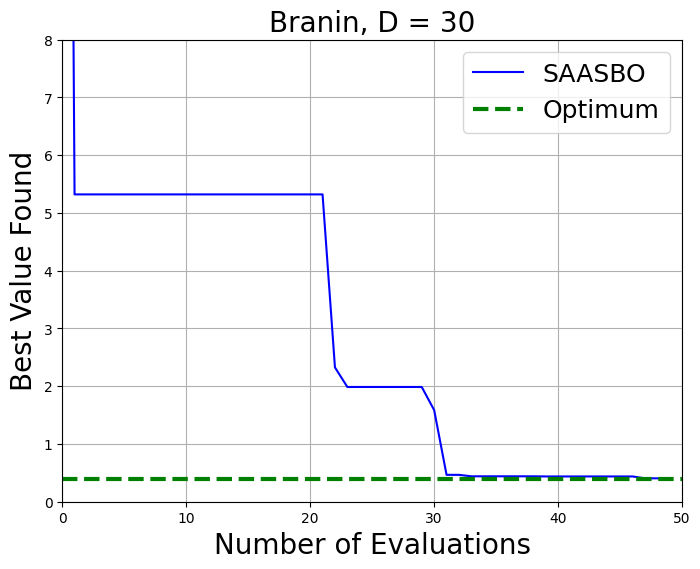

In [21]:
# Plot Results
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Y_np = Y.cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.minimum.accumulate(Y_np), color="b", label="SAASBO")
ax.plot([0, len(Y_np)], [0.398, 0.398], "--", c="g", lw=3, label="Optimum")
ax.grid(True)
ax.set_title(f"Branin, D = {DIM}", fontsize=20)
ax.set_xlabel("Number of Evaluations", fontsize=20)
ax.set_xlim([0, len(Y_np)])
ax.set_ylabel("Best Value Found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

Below, we will refit the model on 50 points and then predict 50 test points to
determine how well the SAAS model predicts out-of-sample points. Additionally,
we will also plot these predictions against their true values in addition to a
95% confidence interval for each test point.

In [22]:
# Initialize New Dataset for Training and Testing
train_X = SobolEngine(dimension=DIM, scramble=True, seed=0).draw(50).to(**tkwargs)
test_X = SobolEngine(dimension=DIM, scramble=True, seed=1).draw(50).to(**tkwargs)
train_Y = branin_emb(train_X).unsqueeze(-1)
test_Y = branin_emb(test_X).unsqueeze(-1)

# Define GP Model
gp = SaasFullyBayesianSingleTaskGP(
    train_X=train_X,
    train_Y=train_Y,
    train_Yvar=torch.full_like(train_Y, 1e-6),
    outcome_transform=Standardize(m=1),
)

# Fit Bayesian Model Using No-U-Turn-Sampler (NUTS)
fit_fully_bayesian_model_nuts(
    gp,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    thinning=THINNING,
    disable_progbar=True,
)

In [23]:
# Compute Posterior Distribution
with torch.no_grad():
    posterior = gp.posterior(test_X)

# Compute Quantiles for Points and their CIs
median = posterior.quantile(value=torch.tensor([0.5], **tkwargs))
q1 = posterior.quantile(value=torch.tensor([0.025], **tkwargs))
q2 = posterior.quantile(value=torch.tensor([0.975], **tkwargs))

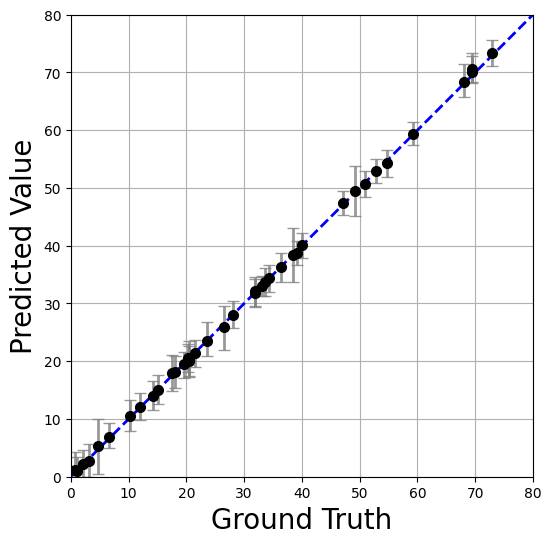

In [24]:
# Plot OOS Prediction Performance
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0, 80], [0, 80], "b--", lw=2)

y_err1, y_err2 = median - q1, q2 - median
y_err = torch.cat((y_err1.unsqueeze(0), y_err2.unsqueeze(0)), dim=0).squeeze(-1)
markers, caps, bars = ax.errorbar(
    test_Y.squeeze(-1).cpu().numpy(),
    median.squeeze(-1).cpu().numpy(),
    yerr=y_err.cpu().numpy(),
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
ax.set_xlim([0, 80])
ax.set_ylim([0, 80])
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlabel("Ground Truth", fontsize=20)
ax.set_ylabel("Predicted Value", fontsize=20)
ax.set_aspect("equal")
ax.grid(True)

Finally, let's inspect the lengthscales from our final model since we expect
that only the first two parameters (0 and 1) to be identified as important by
the SAASBO model. This is confirmed below since the lengthscales for the first
two parameters are small while the other lengthscales are large.

In [25]:
# Inspect Final Model Lengthscales
median_lengthscales = gp.median_lengthscale
for i in median_lengthscales.argsort()[:10]:
    print(f"Parameter{i:2}) Median Lengthscale = {median_lengthscales[i].item():.2e}")

Parameter 0) Median Lengthscale = 6.94e-01
Parameter 1) Median Lengthscale = 2.14e+00
Parameter 4) Median Lengthscale = 3.92e+02
Parameter22) Median Lengthscale = 5.11e+02
Parameter10) Median Lengthscale = 5.15e+02
Parameter13) Median Lengthscale = 5.24e+02
Parameter25) Median Lengthscale = 5.32e+02
Parameter19) Median Lengthscale = 5.61e+02
Parameter14) Median Lengthscale = 5.69e+02
Parameter 9) Median Lengthscale = 6.00e+02


## Bite-Sized Tutorials
The tutorials in this section are focused on specific components often
encountered when customizing Bayesian optimization loops.

### Implementing Custom Acquisition Functions
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/custom_acquisition/)

In this tutorial, we review how to implement a custom acquisition function using
BoTorch machinery. Specifically, we will be implementing the **Upper**
**Confidence Bound (UCB)** acquisition function. The acquisition function
balances the exploration-exploitation tradeoff by assigning a score of
$\mu + \sqrt{\beta}*\sigma$ if the posterior distribution is normal with mean
$\mu$ and variance $\sigma^2$. BoTorch provides the "analytic" version of this
acquisition function within the `UpperConfidenceBound` class as well as a Monte
carlo version in the `qUpperConfidenceBound` class, allowing for $q$-batches of
size greater than 1. We will implement scalarized versions of both of these in
the cells below.

First, we will implement a scalarized version of the q-UCB acquisition function.
This is particularly useful if we are in a multi-output setting wherein we want
to model the effect of a design on more than one metric. To do this, we will
extend the q-UCB acquisition function to accept a multi-output model and then
perform q-UCB on a scalarized version of the multiple outputs using a weight
vector. Luckily, implementing a custom acquisition function is easy as one only
needs to implement the constructor and a `forward` method.

In [26]:
# Load Dependencies
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor

In [27]:
# Implement Scalarized Version of q-UCB

class qScalarizedUpperConfidenceBound(MCAcquisitionFunction):
    """
    This class implements a scalarized version of q-UCB, allowing for
    multi-output models.
    """
    def __init__(
            self,
            model: Model,
            beta: Tensor,
            weights: Tensor,
            sampler: Optional[MCSampler] = None,
    ) -> None:
        super(MCAcquisitionFunction, self).__init__(model=model)
        if sampler is None:
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]))
            
        self.sampler = sampler
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform()
    def forward(self, X:Tensor) -> Tensor:
        """
        Evaluate the scalarized qUCB on the candidate set `X`.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
               design points each.

        Returns:
            Tensor: A `(b)`-dim Tensor of Upper Confidence Bound values at the
                given design points `X`.
        """
        posterior = self.model.posterior(X)
        samples = self.get_posterior_samples(posterior)  # n x b x q x o
        scalarized_samples = samples.matmul(self.weights)  # n x b x q
        mean = posterior.mean  # b x q x o
        scalarized_mean = mean.matmul(self.weights)  # b x q
        ucb_samples = (
            scalarized_mean
            + math.sqrt(self.beta * math.pi / 2)
            * (scalarized_samples - scalarized_mean).abs()
        )
        return ucb_samples.max(dim=-1)[0].mean(dim=0)

Notice that the definition of `qScalarizedUpperConfidenceBound` is very close to
the definition of `qUpperConfidenceBound` and only a few extra lines were needed
to accommodate the scalarization of multiple outputs. The
`@t_batch_mode_transform` decorator makes sure that `X` has an explicit t-batch
dimension. We can achieve the same scalarization effect easily using
`ScalarizedPosteriorTransform` (see the end of this tutorial).

Before attempting to connect this custom acquisition function to a Bayesian
optimization loop, the best practice is to test it first. Thus, we will ensure
that it properly evaluates on a compatible multi-output model using a basic
multi-output `SingleTaskGP` model trained with synthetic data.

In [28]:
# Test Custom Acquisition Function
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

torch.set_default_dtype(torch.double)

# generate synthetic dataset
X = torch.rand(20, 2)
Y = torch.stack([torch.sin(X[:, 0]), torch.cos(X[:, 1])], -1)

# fit multi-output model
gp = SingleTaskGP(train_X=X, train_Y=Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# initialize acquisition function
qSUCB = qScalarizedUpperConfidenceBound(gp, beta=0.1,
                                        weights=torch.tensor([0.1, 0.5]))

In [29]:
# evaluate on single q-batch with q=3
qSUCB(torch.rand(3, 2))

tensor([0.5122], grad_fn=<MeanBackward1>)

In [30]:
# batch-evaluate on two q-batches with q=3
qSUCB(torch.rand(2, 3, 2))

tensor([0.5745, 0.5099], grad_fn=<MeanBackward1>)

This acquisition function is able to handle multi-output models and is thus
ready to be incorporated with an optimization loop. Since BoTorch makes it easy
to swap out acquisition functions, we will not demonstrate that here. Instead,
we will look at how to make a scalarized version of analytic UCB (with $q=1$).

This version of analytic UCB will accommodate multi-output models, assuming a
multivariate normal posterior and $q=1$. Notice that this new class,
`ScalarizedUpperConfidenceBound` subclasses `AnalyticAcquisitionFunction` since
we are not implementing a Monte Carlo batch version (as we did previously).
Compared to the Monte Carlo version, rather than using weights on the samples,
we will directly scalarize the mean vector $\boldsymbol{\mu}$ and covariance
matrix $\boldsymbol{\Sigma}$. Then, we will apply standard UCB on the univariate
normal distribution with mean $w^\intercal\boldsymbol{\mu}$ and variance
$w^\intercal\boldsymbol{\Sigma}w$. Finally, we will also specify `expected_q=1`
in the `@t_batch_mode_transform` decorator to ensure that `X` has `q=1`.

In [31]:
# Implement Scalarized Version of Analytic UCB
from botorch.acquisition import AnalyticAcquisitionFunction

class ScalarizedUpperConfidenceBound(AnalyticAcquisitionFunction):
    """
    This class implements a scalarized version of analytic UCB for use with
    multi-output models.
    """
    def __init__(
        self,
        model: Model,
        beta: Tensor,
        weights: Tensor,
        maximize: bool = True,
    ) -> None:
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X:Tensor) -> Tensor:
        """
        Evaluate the Upper Confidence Bound on the candidate set `X` using
        scalarization.

        Args:
            X: A `(b) x d`-dim Tensor of `(b)` t-batches of `d`-dim design
                points each.
        
        Returns:
            A `(b)`-dim Tensor of Upper Confidence Bound values at the given
                design points `X`.
        """

        self.beta = self.beta.to(X)
        batch_shape = X.shape[:-2]
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        scalarized_mean = means.matmul(self.weights)  # b
        covs = posterior.mvn.covariance_matrix  # b x o x o
        weights = self.weights.view(
            1, -1, 1
        )  # 1 x o x 1 (assume single batch dimension)
        weights = weights.expand(batch_shape + weights.shape[1:])  # b x o x 1
        weights_transpose = weights.permute(0, 2, 1)  # b x 1 x o
        scalarized_variance = torch.bmm(
            weights_transpose, torch.bmm(covs, weights)
        ).view(
            batch_shape
        )  # b
        delta = (self.beta.expand_as(scalarized_mean) * scalarized_variance).sqrt()
        if self.maximize:
            return scalarized_mean + delta
        else:
            return scalarized_mean - delta

Once again, we will test our implementation of scalarized UCB and reuse the
`SingleTaskGP` multi-output model trained on synthetic data from before. Note
that we will pass in an explicit q-batch dimension for consistency, even though
$q=1$.

In [32]:
# initialize acquisition function
SUCB = ScalarizedUpperConfidenceBound(gp, beta=0.1,
                                      weights=torch.tensor([0.1, 0.5]))

In [33]:
# evaluate on a single point
SUCB(torch.rand(1, 2))

tensor([0.5253], grad_fn=<AddBackward0>)

In [34]:
# batch-evaluate on 3 points
SUCB(torch.rand(3, 1, 2))

tensor([0.4296, 0.3640, 0.5512], grad_fn=<AddBackward0>)

As promised, we can use the `ScalarizedPosteriorTransform` class to easily and
automatically handle the scalarization for us. This only requires a couple lines
of code and this class can be used for both the analytic and Monte Carlo
versions.

In [35]:
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound

pt = ScalarizedPosteriorTransform(weights=torch.tensor([0.1, 0.5]))
SUCB = UpperConfidenceBound(gp, beta=0.1, posterior_transform=pt)

### Information-Theoretic Acquisition Functions
[_Link to Tutorial on BoTorch_](https://botorch.org/docs/tutorials/information_theoretic_acquisition_functions/)

In this tutorial, we will focus on information-theoretic acquisition functions
and how to implement them in BoTorch. Additionally, we will review both single-
and multi-objective optimization examples using information-theoretic
acquisition functions.

#### Notation
Before jumping into the implementation part of this tutorial, we will establish
some notation for our optimization setting. First, consider the single-objective
setting where we maximize a function $f: \mathbb{X} \rightarrow \mathbb{R}^{M}$
with $M=1$. In the single-objective setting, the maximum is defined using a
total order over the real numbers. In the multi-objective setting ($M > 1$), the
maximum is defined using the Pareto partial ordering over vectors. We follow
BoTorch's notation to denote the optimal set of inputs and outputs:

\begin{equation*}
    \mathbb{X}^{*} = \argmax_{\mathbf{x}\in\mathbb{X}} f(\mathbf{x})
        \subseteq \mathbb{X}
    \hspace{12pt}\text{and}\hspace{12pt}
    \mathbb{Y}^{*} = \max_{\mathbf{x}\in\mathbb{X}} f(\mathbf{x})
        \subset \mathbb{R}^{M}
\end{equation*}

From the notation above, the collection of optimal input-output pairs is denoted
by $(\mathbb{X}^{*}, \mathbb{Y}^{*})$.

#### Overview of Information-Theoretic Acquisition Functions
The notion of information-theoretic acquisition functions is to use information
theory when determining the utility of an input $\mathbf{x}\in\mathbb{X}$. In
particular, we consider how informative the corresponding observation
$\mathbf{y}\in\mathbb{R}^{M}$ will be to learn more about the distribution of
some stochastic process of the function denoted by $S(f)$. Typically,
information-theoretic acquisition functions use **mutual information (MI)** to
define the utility of data:

\begin{equation*}
    \alpha^{\text{IT}}(\mathbf{x}\vert D_{n}) =
    \text{MI}(\mathbf{y}; S(f)\vert \mathbf{x}, D_{n}) =
    H\left[p(\mathbf{y}\vert D_{n})\right] -
    \mathbb{E}_{p(S(f)\vert D_{n})}
    \left[H\left[p(\mathbf{y}\vert\mathbf{x}), D_{n}, S(f)\right]\right]
\end{equation*}

where $D_{n} = (\mathbf{x}_t, \mathbf{y}_t)_{t=1,\dots,n}$ denotes the data set
of sampled inputs and observations and $H$ denotes the differential entropy. In
literature, the difference between information-theoretic acquisition functions
is the choice of statistic $S$ and the modeling assumptions made in order to
estimate the resulting acquisition function. Therefore, we will review three
particular cases: predictive entropy search, max-value entropy search, and joint
entropy search.

#### Predictive Entropy Search (PES)
The predictive entropy search acquisition function considers the problem of
learning more about the distribution of **optimal inputs**:
$S(f) = \mathbb{X}^{*}$. The PES acquisition function is given by:

\begin{equation*}
    \alpha^{\text{PES}}(\mathbf{x}\vert D_{n}) =
    \text{MI}(\mathbf{y};\mathbb{X}^{*}\vert\mathbf{x},D_{n}) =
    H\left[p(\mathbf{y}\vert D_{n})\right] -
    \mathbb{E}_{p(\mathbb{X}^{*}\vert D_{n})}
    \left[H\left[p(\mathbf{y}\vert\mathbf{x}),D_{n},\mathbb{X}^{*}\right]\right]
\end{equation*}

#### Max-value Entropy Search (MES)
The max-value entropy search acquisition function considers the problem of
learning more about the distribution of the **optimal outputs**:
$S(f) = \mathbb{Y}^{*}$. The MES acquisition function is given by:

\begin{equation*}
    \alpha^{\text{MES}}(\mathbf{x}\vert D_{n}) =
    \text{MI}(\mathbf{y};\mathbb{Y}^{*}\vert\mathbf{x},D_{n}) =
    H\left[p(\mathbf{y}\vert D_{n})\right] -
    \mathbb{E}_{p(\mathbb{Y}^{*}\vert D_{n})}
    \left[H\left[p(\mathbf{y}\vert\mathbf{x}),D_{n},\mathbb{Y}^{*}\right]\right]
\end{equation*}

#### Joint Entropy Search (JES)
The joint entropy search acquisition function considers the problem of learning
more about the distribution of the **pairs of optimal inputs and outputs**:
$S(f) = (\mathbb{X}^{*},\mathbb{Y}^{*})$. The JES acquisition function is given
by:

\begin{equation*}
    \alpha^{\text{JES}}(\mathbf{x}\vert D_{n}) =
    \text{MI}(\mathbf{y};(\mathbb{X}^{*},\mathbb{Y}^{*})\vert\mathbf{x},D_{n}) =
    H\left[p(\mathbf{y}\vert D_{n})\right] -
    \mathbb{E}_{p((\mathbb{X}^{*},\mathbb{Y}^{*})\vert D_{n})}
    \left[H\left[
        p(\mathbf{y}\vert\mathbf{x}),D_{n},(\mathbb{X}^{*},\mathbb{Y}^{*})
    \right]\right]
\end{equation*}

#### Single-Objective Example
We will now work through a single-objective example of information-theoretic
acquisition functions in BoTorch. In particular, we will examine a simplistic,
one-dimensional example with one objective.

In [1]:
# Load Dependencies
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

In [2]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")
tkwargs = {"dtype": torch.double, "device": "cpu"}

First, we will define the objective function.

In [3]:
# Define Objective Function
def f(x):
    p1 = torch.cos(torch.pi * x)
    p2 = 10 * torch.sin(torch.pi * x)
    p3 = 2 * torch.sin(2 * torch.pi * x)
    p4 = 2 * torch.sin(6 * torch.pi * x)
    return p1 + p2 + p3 + p4

# Define Bounds
bounds = torch.tensor([[0.0], [1.0]], **tkwargs)

Next, we will generate some data and use it to fit the GP model.

In [4]:
torch.manual_seed(0)
np.random.seed(0)
n = 5
train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=12345678).squeeze(-2)
train_Y = f(train_X)

# Fit GP Model
def fit_model(train_X, train_Y, n_outputs):
    model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        outcome_transform=Standardize(m=n_outputs)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

model = fit_model(train_X, train_Y, n_outputs=1)

Now, we will plot the objective function and the fitted model.

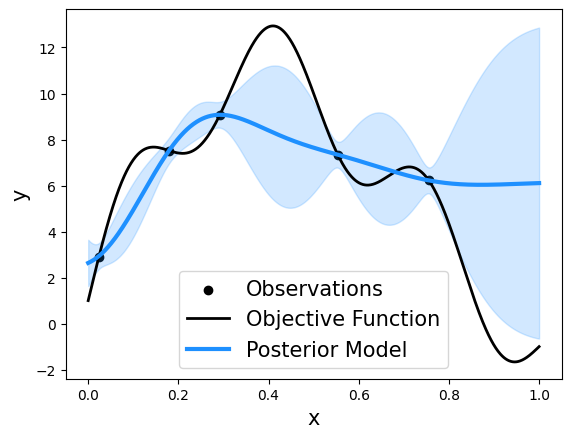

In [6]:
# Plot Objective Function and Fitted GP Model
X = torch.linspace(bounds[0, 0], bounds[1, 0], 1000, **tkwargs)
mean_fX = model.posterior(X).mean.squeeze(-1).detach().numpy()
std_fX = torch.sqrt(model.posterior(X).variance).squeeze(-1).detach().numpy()

plt.scatter(train_X, train_Y, color="k", label="Observations")
plt.plot(X, f(X), color="k", linewidth=2, label="Objective Function")
plt.plot(X, mean_fX, color="dodgerblue", linewidth=3, label="Posterior Model")
plt.fill_between(
    X, (mean_fX + 3 * std_fX), (mean_fX - 3 * std_fX), alpha=0.2, color="dodgerblue"
)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Before we can compute information-theoretic acquisition functions, we need to
obtain Monte Carlo samples of the optimal inputs and outputs. We can use
BoTorch's `sample_optimal_points` method to generate `n_samples` approximate
samples of the GP model and optimizes them sequentially using an optimizer.

Since we are in the single-objective setting, `n_points` should be set to one.
Note that for simplicity, the tutorial uses optimization via random search.

In [7]:
# Obtain Monte Carlo Samples
from botorch.acquisition.utils import get_optimal_samples

n_samples = 12

optimal_inputs, optimal_outputs = get_optimal_samples(
    model=model,
    bounds=bounds,
    num_optima=n_samples
)

After obtaining the Monte Carlo samples, we can now initialize the
information-theoretic acquisition functions. For PES, we only need the optimal
set of inputs. However, for MES and JES, it is also required that we specify the
region of integration: $\mathbf{y}:\mathbf{y}\preceq\mathbb{Y}^{*}$ for a
maximization problem. To specify the region of integration in BoTorch we can
provide a Tensor of bounds using the `compute_sample_box_decomposition` method.

Be aware that for MES, we will use the multi-objective implementation since it
implements all the types of estimation into a single acquisition function. There
are also other strategies to estimate single-objective MES algorithms in the
`botorch.acquisition.max_value_entropy` module.

Finally, in the code below we use the lower bound estimates for MES and JES. For
single-objective MES, the interface is different in that it uses the Gumbel
max-value approximation that does not require max values as input.

In [8]:
# Initialize Acquisition Functions
from botorch.acquisition.predictive_entropy_search import qPredictiveEntropySearch
from botorch.acquisition.max_value_entropy_search import qLowerBoundMaxValueEntropy
from botorch.acquisition.joint_entropy_search import qJointEntropySearch

pes = qPredictiveEntropySearch(model=model, optimal_inputs=optimal_inputs)

mes_lb = qLowerBoundMaxValueEntropy(model=model,
                                    candidate_set=torch.rand(1000,1))

jes_lb = qJointEntropySearch(model=model,
                             optimal_inputs=optimal_inputs,
                             optimal_outputs=optimal_outputs,
                             estimation_type="LB")

Next, we will illustrate the acquisition functions by evaluating it over the
domain and plot it.

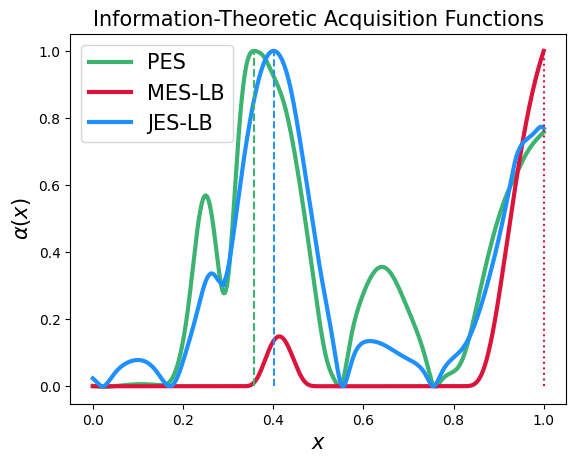

In [9]:
# Plot Acquisition Functions Over Entire Domain
fwd_X = X.unsqueeze(-1).unsqueeze(-1)       # the AFs accept a 3D tensor
scale_acqvals = True                        # ensure AFs live on the same scale

# Evaluate Acquisition Functions
pes_X = pes(fwd_X).detach().numpy()
mes_lb_X = mes_lb(fwd_X).detach().numpy()
jes_lb_X = jes_lb(fwd_X).detach().numpy()

if scale_acqvals:
    pes_X = pes_X / pes_X.max()
    mes_lb_X = mes_lb_X / mes_lb_X.max()
    jes_lb_X = jes_lb_X / jes_lb_X.max()

plt.plot(X, pes_X, color="mediumseagreen", linewidth=3, label="PES")
plt.plot(X, mes_lb_X, color="crimson", linewidth=3, label="MES-LB")
plt.plot(X, jes_lb_X, color="dodgerblue", linewidth=3, label="JES-LB")

plt.vlines(
    X[pes_X.argmax()], 0, 1, color="mediumseagreen", linewidth=1.5,
    linestyle="--"
)
plt.vlines(
    X[mes_lb_X.argmax()], 0, 1, color="crimson", linewidth=1.5, linestyle=":"
)
plt.vlines(
    X[jes_lb_X.argmax()], 0, 1, color="dodgerblue", linewidth=1.4,
    linestyle="--"
)
plt.legend(fontsize=15)
plt.xlabel("$x$", fontsize=15)
plt.ylabel(r"$\alpha(x)$", fontsize=15)
plt.title("Information-Theoretic Acquisition Functions", fontsize=15)
plt.show()

We can maximize the acquisition function within a standard Bayesian optimization
loop using standard optimization routines. However, since the PES acquisition
function may not be differentiable at certain points, we will use a finite
difference approach to optimize PES.

In [10]:
# Maximize Acquisition Functions
from botorch.optim import optimize_acqf

candidate, acq_value = optimize_acqf(
    acq_function=pes,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
    options={"with_grad": False},
)
print(f"PES: candidate={candidate}, acq_value={acq_value}")

candidate, acq_value = optimize_acqf(
    acq_function=mes_lb,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
)
print(f"MES-LB:, candidate={candidate}, acq_value={acq_value}")

candidate, acq_value = optimize_acqf(
    acq_function=jes_lb,
    bounds=bounds,
    q=1,
    num_restarts=4,
    raw_samples=256,
)
print(f"JES-LB: candidate={candidate}, acq_value={acq_value}")

PES: candidate=tensor([[0.3580]], dtype=torch.float64), acq_value=0.1971753818790028
MES-LB:, candidate=tensor([[1.]], dtype=torch.float64), acq_value=0.02155558019962198
JES-LB: candidate=tensor([[0.4009]], dtype=torch.float64), acq_value=0.5871791664993515


#### Multi-Objective Example
Here, we will work through a multi-objective example of information-theoretic
acquisition functions in BoTorch. Just as in the single-objective example above,
we begin by generating some data and fitting the model.

In [11]:
from botorch.acquisition.multi_objective.utils import (
    compute_sample_box_decomposition,
    random_search_optimizer,
    sample_optimal_points,
)
from botorch.test_functions.multi_objective import ZDT1

d = 4   # number of dimensions
M = 2   # number of objectives
n = 8   # number of samples

q = 2 if SMOKE_TEST else 4

# Define Problem and Bounds
problem = ZDT1(dim=d, num_objectives=M, noise_std=0, negate=True)
bounds = problem.bounds.to(**tkwargs)

# Generate Training Data
train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=123).squeeze(-2)
train_Y = problem(train_X)

# Fit GP Model
model = fit_model(train_X, train_Y, n_outputs=M)

Next, we need to obtain Monte Carlo samples of the optimal inputs and outputs.

In [12]:
# Obtain Monte Carlo Samples
n_pareto_samples = 8
n_pareto_points = 8

optimizer_kwargs = {
    "pop_size": 500,
    "max_tries": 10,
}

ps, pf = sample_optimal_points(
    model=model,
    bounds=bounds,
    num_samples=n_pareto_samples,
    num_points=n_pareto_points,
    optimizer=random_search_optimizer,
    optimizer_kwargs=optimizer_kwargs,
)

Initialize the acquisition functions in the same manner as before.

In [13]:
from botorch.acquisition.multi_objective.joint_entropy_search import (
    qLowerBoundMultiObjectiveJointEntropySearch,
)
from botorch.acquisition.multi_objective.max_value_entropy_search import (
    qLowerBoundMultiObjectiveMaxValueEntropySearch,
)
from botorch.acquisition.multi_objective.predictive_entropy_search import (
    qMultiObjectivePredictiveEntropySearch,
)

pes = qMultiObjectivePredictiveEntropySearch(
    model=model,
    pareto_sets=ps
)

# Compute box-decomposition for MES and JES
hypercell_bounds = compute_sample_box_decomposition(pf)

# Use Lower Bound Estimates for MES and JES
mes_lb = qLowerBoundMultiObjectiveMaxValueEntropySearch(
    model=model,
    hypercell_bounds=hypercell_bounds,
    estimation_type="LB",
)

jes_lb = qLowerBoundMultiObjectiveJointEntropySearch(
    model=model,
    pareto_sets=ps,
    pareto_fronts=pf,
    hypercell_bounds=hypercell_bounds,
    estimation_type="LB",
)

Finally, we can optimize the batch acquisition functions. We directly optimize
batch PES while MES and JES use a sequential strategy.

In [16]:
candidates, acq_values = optimize_acqf(
    acq_function=pes,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=256,
    options={"with_grad": False},
)
print(f"PES: \ncandidates={candidates}")

PES: 
candidates=tensor([[0.0000, 0.0890, 0.5066, 0.0880],
        [0.0000, 0.1520, 0.9598, 0.0439],
        [0.0167, 0.5638, 0.0704, 0.1453],
        [0.1337, 0.0000, 1.0000, 1.0000]], dtype=torch.float64)


In [17]:
candidates, acq_values = optimize_acqf(
    acq_function=mes_lb,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=512,
    sequential=True,
)
print(f"MES-LB: \ncandidates={candidates}")

MES-LB: 
candidates=tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0939, 0.7365, 0.0000]], dtype=torch.float64)


In [18]:
candidates, acq_values = optimize_acqf(
    acq_function=jes_lb,
    bounds=bounds,
    q=q,
    num_restarts=4,
    raw_samples=512,
    sequential=True,
)
print(f"JES-LB: \ncandidates={candidates}")

JES-LB: 
candidates=tensor([[0.0000, 0.8340, 0.8803, 0.7352],
        [0.0000, 0.2053, 0.9372, 0.4867],
        [0.0303, 0.5216, 0.0984, 0.2052],
        [0.6156, 0.0579, 0.4433, 0.4013]], dtype=torch.float64)


## Advanced Usage
The tutorials in this section are focused on advanced BoTorch approaches.